In [2]:
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import tqdm

# Not required.
# import fitz  # !pip install PyMuPDF

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report

import torch
from torch.nn import Module
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms


# Training Data is taken from Kaggle 
# https://www.kaggle.com/datasets/harieh/ocr-dataset

# Reference Repo
# https://www.kaggle.com/code/saadurrehman97/optical-character-recognition-ocr-using-dl

In [3]:
# Define helper methods to load the dataset for training
def directory_to_dataframe(path: str) -> pd.DataFrame: 
    """Loads a directory into a dataframe object to train on.

    Args:
        path (str): the location of the directory to load into training

    Returns:
        pd.DataFrame: the dataset data loaded into the dataframe
    """
    folders = os.listdir(path)
    df = []
    for folder in folders:
        if "_" in folder:
            label = Path(folder).name.split("_")[0]
        else:
            label = Path(folder).name
        cur_path = os.path.join(path, folder)
        for sample in os.listdir(cur_path): 
            img_path = os.path.join(cur_path, sample)
            df.append([img_path, label])
        
    df = pd.DataFrame(df, columns=['image', 'label'])
    return df.copy()


def image_to_numpy(path: str) -> torch.tensor: 
    """Loads an image at specified path to an numpy array in gray scale
    **NOTE** this means the the images have one channel

    Args:
        path (str): the path location of the image

    Returns:
        np.array: the image in np array format
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transforms.ToTensor()(image)
    return image


def display_image(img: np.array, label:str = None) -> None: 
    """Displays an image to the user.

    Args:
        img (np.array): the np array of the image to show to the user
        label (str): the label to display the image with (if any)
    """
    img = transforms.ToPILImage()(img)
    plt.imshow(img)
    plt.axis(False)
    plt.title(label)
    plt.show()

(210227, 2)
torch.Size([3, 60, 40])


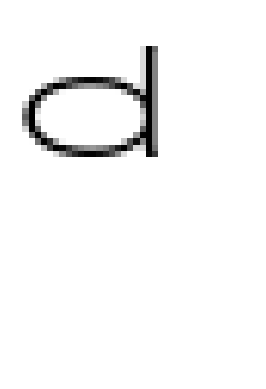

In [4]:
# Define the pre-defined hyperparameters
BATCH_SIZE = 16

# Load the dataset
df = directory_to_dataframe(os.path.join(os.getcwd(), "train"))

# Print the df shape
print(df.shape)

# Convert image to np.array
print(image_to_numpy(df["image"][0]).shape)

# Display image 
display_image(image_to_numpy(df["image"][100000]))

In [190]:
# Convert the dataframe to a dataset
class CharacterDataset(Dataset): 
    """ Converts the dataframe of data into a dataset that can be dataloader with pytorch """
    def __init__(self, frame):
        self.frame = frame
    
    def __len__(self): 
        return len(self.frame) 
    
    def __getitem__(self, index):
        # return x,y 
        return (image_to_numpy(self.frame['image'][index]), self.frame['label'][index])
    

# Convert the labels to integer representations
le = preprocessing.LabelEncoder()
le.fit(df['label'])
df['label'] = le.transform(df['label'])

# Convert the dataset into train and test 
X, y = df['image'], df['label']

X_rest, _, y_rest, _ = train_test_split(X, y, test_size=0.50)  # use 50% of the data for training and testing 
X_train, X_test, y_train, y_test = train_test_split(X_rest, y_rest, test_size=0.20)  # 80/20 split for train test 
training_dataset = CharacterDataset(pd.concat((X_train, y_train), axis=1).reset_index())
testing_dataset = CharacterDataset(pd.concat((X_test, y_test), axis=1).reset_index())


train_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True)

for img, label in train_dataloader: 
    # a batch of 32 (60, 40) images
    print(img.shape, label)
    break

torch.Size([16, 3, 60, 40]) tensor([10, 17, 47,  0, 59, 40, 45, 48, 25, 26, 60, 10, 27, 25, 54, 60])


In [191]:

# Define the model to train using a Conv2D model
class SingleCharacterOCR(Module): 
    def __init__(self): 
        super().__init__()
        self.stack = torch.nn.Sequential(
            torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(3, 128, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3),
            torch.nn.Conv2d(128, 256, stride=2, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.2),
            torch.nn.Flatten(),
            torch.nn.Linear(3840, 1024), 
            torch.nn.ReLU(),
            torch.nn.Linear(1024, len(le.classes_))
            # nn.Softmax(10)  Cross Entropy Loss does softmax
        )

    def forward(self, x): 
        return self.stack(x)


In [ ]:
# Define the train function 
device = 'cpu'

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    avg_loss = test_loss / num_batches
    accuracy = correct / size
    print(f"The average loss is: {avg_loss}")
    print(f"The accuracy is of the neural net is: {accuracy}")
    return avg_loss, accuracy

In [ ]:
# Training Process
# Model 1 - Single Character OCR Model
character_ocr_model = SingleCharacterOCR()

# Use the Cross Entropy Loss and Adam Optimizer with learning rate of 1e-4
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(character_ocr_model.parameters(), lr=1e-4)

epochs = 8
loss_results = []
accuracy_results = []
print("Character Model ----")
for t in tqdm.trange(epochs, desc="Epochs"):
    train(train_dataloader, character_ocr_model, loss_fn, optimizer)
    loss, accuracy = test(test_dataloader, character_ocr_model, loss_fn)
    loss_results.append(loss)
    accuracy_results.append(accuracy)

# save the model to the computer
torch.save(character_ocr_model, 'model/model.pth') 

plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.plot(list(range(1, epochs+1)), loss_results)
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(list(range(1, epochs+1)), accuracy_results)
plt.show()

Character Model ----


Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

loss: 4.131779  [   16/84090]
loss: 4.124995  [ 1616/84090]
loss: 4.148274  [ 3216/84090]
loss: 3.503349  [ 4816/84090]
loss: 2.764078  [ 6416/84090]
loss: 3.083665  [ 8016/84090]
loss: 1.129071  [ 9616/84090]
loss: 2.042734  [11216/84090]
loss: 1.880218  [12816/84090]
loss: 1.288345  [14416/84090]
loss: 2.048794  [16016/84090]
loss: 1.898945  [17616/84090]
loss: 1.230708  [19216/84090]
loss: 1.364013  [20816/84090]
loss: 0.884538  [22416/84090]
loss: 1.196752  [24016/84090]
loss: 0.896292  [25616/84090]
loss: 1.125417  [27216/84090]
loss: 0.974984  [28816/84090]
loss: 1.050552  [30416/84090]
loss: 1.085866  [32016/84090]
loss: 1.010725  [33616/84090]
loss: 2.043817  [35216/84090]
loss: 0.599706  [36816/84090]
loss: 0.804273  [38416/84090]
loss: 0.729700  [40016/84090]
loss: 0.814974  [41616/84090]
loss: 0.702494  [43216/84090]
loss: 0.943755  [44816/84090]
loss: 0.951139  [46416/84090]
loss: 1.232211  [48016/84090]
loss: 0.590181  [49616/84090]
loss: 1.436202  [51216/84090]
loss: 0.25

Epochs:  12%|█▎        | 1/8 [05:14<36:42, 314.69s/it]

The average loss is: 0.6709621141776669
The accuracy is of the neural net is: 0.8263330637872806
loss: 0.548908  [   16/84090]
loss: 1.290494  [ 1616/84090]
loss: 0.271925  [ 3216/84090]
loss: 0.555954  [ 4816/84090]
loss: 2.073822  [ 6416/84090]
loss: 0.771847  [ 8016/84090]
loss: 0.944472  [ 9616/84090]
loss: 0.230428  [11216/84090]
loss: 1.539187  [12816/84090]
loss: 0.554819  [14416/84090]
loss: 0.693347  [16016/84090]
loss: 1.108515  [17616/84090]
loss: 0.869302  [19216/84090]
loss: 0.336095  [20816/84090]
loss: 0.400327  [22416/84090]
loss: 1.046428  [24016/84090]
loss: 0.137379  [25616/84090]
loss: 0.537329  [27216/84090]
loss: 0.850296  [28816/84090]
loss: 1.553830  [30416/84090]
loss: 0.178211  [32016/84090]
loss: 0.814396  [33616/84090]
loss: 0.629120  [35216/84090]
loss: 0.366131  [36816/84090]
loss: 0.590862  [38416/84090]
loss: 0.627830  [40016/84090]
loss: 0.504389  [41616/84090]
loss: 1.010294  [43216/84090]
loss: 0.505430  [44816/84090]
loss: 0.791447  [46416/84090]
los

Epochs:  25%|██▌       | 2/8 [10:48<32:36, 326.13s/it]

The average loss is: 0.5301139535193857
The accuracy is of the neural net is: 0.8605337011844171
loss: 0.525739  [   16/84090]
loss: 0.460300  [ 1616/84090]
loss: 0.442511  [ 3216/84090]
loss: 0.741818  [ 4816/84090]
loss: 0.410955  [ 6416/84090]
loss: 1.008177  [ 8016/84090]
loss: 0.262055  [ 9616/84090]
loss: 0.887087  [11216/84090]
loss: 0.284282  [12816/84090]
loss: 0.513434  [14416/84090]
loss: 0.526192  [16016/84090]
loss: 0.869460  [17616/84090]
loss: 0.783414  [19216/84090]
loss: 0.063576  [20816/84090]
loss: 0.434301  [22416/84090]
loss: 0.262779  [24016/84090]
loss: 0.087405  [25616/84090]
loss: 0.801460  [27216/84090]
loss: 0.437631  [28816/84090]
loss: 0.327868  [30416/84090]
loss: 0.472780  [32016/84090]
loss: 0.401472  [33616/84090]
loss: 0.211813  [35216/84090]
loss: 0.911534  [36816/84090]
loss: 0.498889  [38416/84090]
loss: 0.414895  [40016/84090]
loss: 0.747738  [41616/84090]
loss: 0.485036  [43216/84090]
loss: 0.599150  [44816/84090]
loss: 0.098406  [46416/84090]
los

Epochs:  38%|███▊      | 3/8 [16:16<27:14, 326.88s/it]

The average loss is: 0.4541716540184104
The accuracy is of the neural net is: 0.8764686295961566
loss: 0.380329  [   16/84090]
loss: 1.087285  [ 1616/84090]
loss: 0.396196  [ 3216/84090]
loss: 0.327125  [ 4816/84090]
loss: 0.459622  [ 6416/84090]
loss: 0.113517  [ 8016/84090]
loss: 0.874857  [ 9616/84090]
loss: 0.256222  [11216/84090]
loss: 0.682774  [12816/84090]
loss: 0.437854  [14416/84090]
loss: 0.213436  [16016/84090]
loss: 0.349373  [17616/84090]
loss: 0.699037  [19216/84090]
loss: 0.468344  [20816/84090]
loss: 0.065939  [22416/84090]
loss: 0.799533  [24016/84090]
loss: 0.890466  [25616/84090]
loss: 1.021576  [27216/84090]
loss: 0.163496  [28816/84090]
loss: 0.630019  [30416/84090]
loss: 0.083085  [32016/84090]
loss: 0.517903  [33616/84090]
loss: 0.155802  [35216/84090]
loss: 0.433148  [36816/84090]
loss: 0.482835  [38416/84090]
loss: 0.336504  [40016/84090]
loss: 0.064251  [41616/84090]
loss: 0.281069  [43216/84090]
loss: 0.036212  [44816/84090]
loss: 0.739135  [46416/84090]
los

Epochs:  50%|█████     | 4/8 [21:38<21:39, 324.99s/it]

The average loss is: 0.4203815399571655
The accuracy is of the neural net is: 0.8853636493364411
loss: 0.016696  [   16/84090]
loss: 0.566373  [ 1616/84090]
loss: 0.326568  [ 3216/84090]
loss: 0.131327  [ 4816/84090]
loss: 0.032169  [ 6416/84090]
loss: 0.653499  [ 8016/84090]
loss: 0.166515  [ 9616/84090]
loss: 0.184751  [11216/84090]
loss: 0.064511  [12816/84090]
loss: 0.325184  [14416/84090]
loss: 0.290934  [16016/84090]
loss: 0.538213  [17616/84090]
loss: 0.032111  [19216/84090]
loss: 0.715371  [20816/84090]
loss: 0.331583  [22416/84090]
loss: 0.758271  [24016/84090]
loss: 0.336387  [25616/84090]
loss: 0.344603  [27216/84090]
loss: 1.128757  [28816/84090]
loss: 0.619422  [30416/84090]
loss: 0.320624  [32016/84090]
loss: 0.302669  [33616/84090]
loss: 0.229226  [35216/84090]
loss: 0.290816  [36816/84090]
loss: 0.684838  [38416/84090]
loss: 0.779598  [40016/84090]
loss: 0.669830  [41616/84090]
loss: 0.205932  [43216/84090]
loss: 0.655012  [44816/84090]
loss: 1.442766  [46416/84090]
los

Epochs:  62%|██████▎   | 5/8 [26:56<16:07, 322.45s/it]

The average loss is: 0.39669591789112585
The accuracy is of the neural net is: 0.8899300765827903
loss: 0.256457  [   16/84090]
loss: 0.223903  [ 1616/84090]
loss: 0.107789  [ 3216/84090]
loss: 0.360139  [ 4816/84090]
loss: 0.316187  [ 6416/84090]
loss: 0.014449  [ 8016/84090]
loss: 0.267634  [ 9616/84090]
loss: 0.026035  [11216/84090]
loss: 0.522901  [12816/84090]
loss: 0.308269  [14416/84090]
loss: 0.027986  [16016/84090]
loss: 0.226671  [17616/84090]
loss: 0.166474  [19216/84090]
loss: 0.353224  [20816/84090]
loss: 0.393896  [22416/84090]
loss: 0.452433  [24016/84090]
loss: 0.079392  [25616/84090]
loss: 0.406402  [27216/84090]
loss: 0.328408  [28816/84090]
loss: 0.760091  [30416/84090]
loss: 0.254839  [32016/84090]
loss: 0.085413  [33616/84090]
loss: 0.523148  [35216/84090]
loss: 0.187707  [36816/84090]
loss: 0.180410  [38416/84090]
loss: 0.444107  [40016/84090]
loss: 0.005575  [41616/84090]
loss: 0.170664  [43216/84090]
loss: 0.385514  [44816/84090]
loss: 0.877838  [46416/84090]
lo

Epochs:  75%|███████▌  | 6/8 [32:17<10:43, 321.99s/it]

The average loss is: 0.3905583535000516
The accuracy is of the neural net is: 0.8940684012747943
loss: 0.215266  [   16/84090]
loss: 0.050485  [ 1616/84090]
loss: 0.127628  [ 3216/84090]
loss: 0.265636  [ 4816/84090]
loss: 0.043852  [ 6416/84090]
loss: 0.463038  [ 8016/84090]
loss: 0.060464  [ 9616/84090]
loss: 0.010194  [11216/84090]
loss: 0.077993  [12816/84090]
loss: 0.112993  [14416/84090]
loss: 0.151564  [16016/84090]
loss: 0.250105  [17616/84090]
loss: 0.249195  [19216/84090]
loss: 0.231829  [20816/84090]
loss: 0.151610  [22416/84090]
loss: 0.196952  [24016/84090]
loss: 0.234055  [25616/84090]
loss: 0.116336  [27216/84090]
loss: 0.272074  [28816/84090]
loss: 0.099518  [30416/84090]
loss: 0.032695  [32016/84090]
loss: 0.121500  [33616/84090]
loss: 0.441746  [35216/84090]
loss: 0.271376  [36816/84090]
loss: 0.103211  [38416/84090]
loss: 0.345967  [40016/84090]
loss: 0.159165  [41616/84090]
loss: 0.215698  [43216/84090]
loss: 0.363136  [44816/84090]
loss: 0.321445  [46416/84090]
los

Epochs:  88%|████████▊ | 7/8 [37:37<05:21, 321.20s/it]

The average loss is: 0.3804707588977712
The accuracy is of the neural net is: 0.8969699852542453
loss: 0.621632  [   16/84090]
loss: 0.271649  [ 1616/84090]
loss: 0.287864  [ 3216/84090]
loss: 0.171275  [ 4816/84090]
loss: 0.047740  [ 6416/84090]
loss: 0.514884  [ 8016/84090]
loss: 0.618788  [ 9616/84090]
loss: 0.512773  [11216/84090]
loss: 0.406552  [12816/84090]
loss: 0.389037  [14416/84090]
loss: 0.266325  [16016/84090]
loss: 0.206477  [17616/84090]
loss: 0.659567  [19216/84090]
loss: 0.106554  [20816/84090]
loss: 0.031797  [22416/84090]
loss: 0.062030  [24016/84090]
loss: 0.453347  [25616/84090]
loss: 0.404219  [27216/84090]
loss: 0.503911  [28816/84090]
loss: 0.018228  [30416/84090]
loss: 0.319969  [32016/84090]
loss: 0.683658  [33616/84090]
loss: 0.459829  [35216/84090]
loss: 0.367955  [36816/84090]
loss: 0.069622  [38416/84090]
loss: 0.424433  [40016/84090]
loss: 0.385867  [41616/84090]
loss: 0.120167  [43216/84090]
loss: 0.364005  [44816/84090]
loss: 0.103200  [46416/84090]
los

Epochs: 100%|██████████| 8/8 [43:01<00:00, 322.73s/it]

The average loss is: 0.3792523704970658
The accuracy is of the neural net is: 0.8985872615706607


RuntimeError: File model cannot be opened.

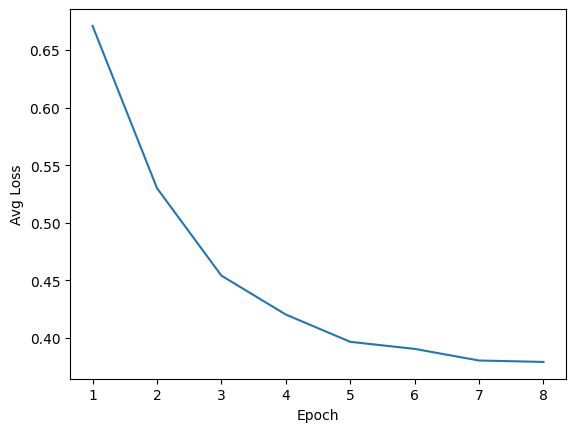

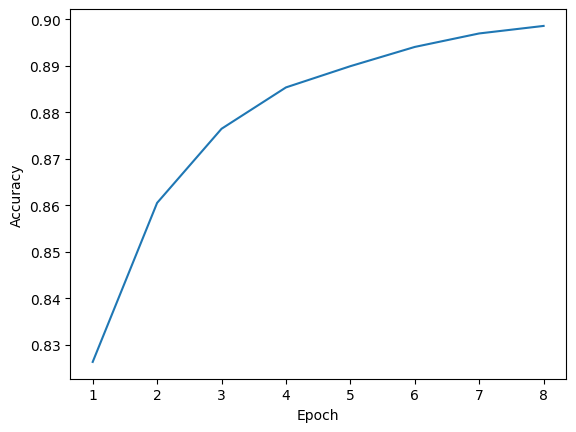

In [ ]:
torch.save(character_ocr_model, 'model.pth') 

plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.plot(list(range(1, epochs+1)), loss_results)
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(list(range(1, epochs+1)), accuracy_results)
plt.show()

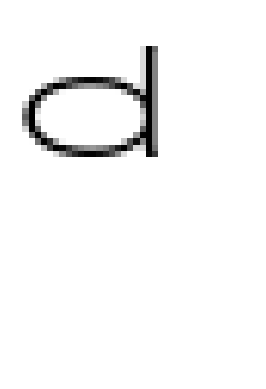

The label is d


In [ ]:
# An example of character OCR working
display_image(image_to_numpy(df["image"][100000]))
character_ocr_model.eval()
with torch.no_grad():
    print("The label is", le.inverse_transform(character_ocr_model(image_to_numpy(df["image"][100000]).unsqueeze(0)).reshape(-1, 1).argmax(axis=0)).item())


In [188]:
# Now that we have trained the character recognition model, lets use this character recognition model to create our own 
# document OCR 

# Using a sample of 10 pages taken from the 
# Artificial Intelligence - A Modern Approach (3rd Edition).pdf
# (fun program)

# def generate_test_documents(path: str, n: int) -> None:
#     """ Generates n number of images based on a pdf provided at path """
#     doc = fitz.open(path)
#     num_pages = len(doc)
#     for i in range(n):
#         r_page_num = random.randint(0, num_pages-1)
#         page = doc.load_page(r_page_num)
#         pixmap = page.get_pixmap(dpi=300)
#         img = pixmap.tobytes()
#         with open(f'documents/doc{i+1}.jpg', 'wb') as f:
#             f.write(img)
    

def naive_document_segementation(path: str, segment_height=60, segment_width=40) -> list:
    """Segments a document at a path into (60x40) images.

    Args:
        path (str): the image path to segment into smaller images
        segment_height (int, optional): the height of the segment. Defaults to 60.
        segment_width (int, optional): the width of the segment. Defaults to 40.

    Returns:
        list: the list of image segments from left to right up to down that we want process with ocr.
    """
    img = cv2.imread(path)
    height, width, channels = img.shape
    
    # read the image left to right like english to produce a list of 60,40 pixels 
    img_segments = []
    for start_y in range(0, height - segment_height + 1, segment_height): 
        for start_x in range(0, width - segment_width +1, segment_width):
            segment = img[start_y:start_y+segment_height, start_x: start_x+segment_width, :]
            segment = cv2.cvtColor(segment, cv2.COLOR_BGR2RGB)    
            img_segments.append(transforms.ToTensor()(segment))

    return img_segments


def document_ocr(model, img_segments: list) -> list:
    """Computes the OCR of the specified documents based on the image segments of the document.
    
    Keyword arguments:
    img_segments (list) -- the image segments the document is split up into
    Return (list): the list of characters recognized by the ocr engine 
    """
    results = []
    for segment in img_segments: 
        model.eval()
        with torch.no_grad():
            result = model(segment.unsqueeze(0))
            result = result.reshape(-1, 1).argmax(axis=0)
        results.append(le.inverse_transform(result).item())
        
    return results


def calculate_accuracy(model, segmentation, documents_dir: str, results_dir: str): 
    """To calculate accuracy for the OCR model we have a set of labeled documents in the documents dir 
       and a set of labeled result translations (human labeled). The accuracy metric will calculate the perctange 
       of letters similar between the expected OCR and the actual result.
       
       Difference is calculated with a range of 0-1 with a difference of 0 meaning the documents are similar and a difference of 1 
       meaning that the documents are very different
    Args:
        model (_type_): the model used to perform the ocr
        segmentation (function): the type of segmentation to perform
        documents_dir (str): the documents directory where to perform OCR
        results_dir (str): the results directory where to compare results with
    """
    for fname in os.listdir(documents_dir): 
        cur_path = os.path.join(documents_dir, fname)
        difference = 0
        
        if not os.path.isfile(cur_path) or Path(cur_path).suffix not in [".png", ".jpeg", ".jpg", ".webp"]: 
            continue
        
        img_segments = segmentation(cur_path)
        results = document_ocr(model, img_segments)
        
        # Calculate expected count
        expected_count = {}
        for c in results:
            if c not in expected_count:
                expected_count[c] = 1
            else:
                expected_count[c] += 1
                
        # Calculate actual count
        if Path(fname).with_suffix('.txt').name in os.listdir(results_dir):
            actual_fpath = os.path.join(results_dir, Path(fname).with_suffix('.txt'))
        else:
            continue
        # Calculate actual count
        with open(actual_fpath, 'r') as f:
            actual_txt = f.read()
            
        actual_count = {}
        total_chars = 0
        for c in actual_txt:
            if c not in actual_count:
                actual_count[c] = 1
            else:
                actual_count[c] += 1
            total_chars += 1
            
        # Now compare similarity between the two
        for key, value in actual_count.items(): 
            if key in expected_count: 
                actual_count[key] -= expected_count[key]
                
        for key, value in actual_count.items():
            if value > 0: 
                difference += value
        
        difference = difference / total_chars
        
        print(f'Difference between {cur_path} and ocr is: {difference}')
    
    

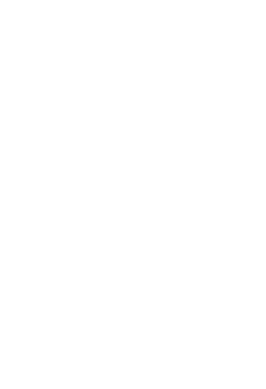

In [15]:
# NOTE: this document segmentation technique is very naive hence the poor accuracy results when testing on actual documents
# ideally every segment produced from segmentation should be a signal character
segments = naive_document_segementation("documents/doc1.png")
for i, se in enumerate(segments):
    if i > 0: 
        break
    display_image(se)

In [ ]:
# Calculate the accuracy between the ocr made and the actual docs
calculate_accuracy(character_ocr_model, naive_document_segementation, "documents", "results")

NameError: name 'character_ocr_model' is not defined

In [193]:
# Try to improve the segmentation for better results
def better_document_segementation(path: str, segment_height=60, segment_width=40, threshold=200) -> list:
    """Segments a document at a path into (60x40) images checking for blanks and filling in white space when there is a.

    Args:
        path (str): the image path to segment into smaller images
        segment_height (int, optional): the height of the segment. Defaults to 60.
        segment_width (int, optional): the width of the segment. Defaults to 40.

    Returns:
        list: the list of image segments from left to right up to down that we want process with ocr.
    """
    img = cv2.imread(path)
    height, width, channels = img.shape
    
    # read the image left to right like english to produce a list of 60,40 pixels 
    img_segments = []
    for start_y in range(0, height - segment_height + 1, segment_height): 
        cols = []
        segments = []
        for x in range(0, width, 1):
            col = img[start_y:start_y+segment_height, x, :]
            col = col.reshape((segment_height, 1, channels))

            # check if the col is almost all white pixels then skip the col if its not the end of a sequence
            if ((np.ones((segment_height, 1, channels)) * 255) - col).sum() < threshold and cols == []:
                continue
            # check if the col is almost all white and the end of a sequence
            elif ((np.ones((segment_height, 1, channels)) * 255) - col).sum() < threshold and cols != []:
                cols.append(col)
                segments.append(np.hstack(cols))
                cols = []
            # check that the col must contain some other pixels
            else:
                cols.append(col)

            # check if the len of cols == segment_width then we need to break them up
            if (len(cols) == segment_width):
                segments.append(np.hstack(cols))
                cols = []
            
            
        for segment in segments:
            # if the segment shape is not at the img_width then we add white rows to the end of the segment
            if segment.shape[1] < segment_width:
                filler = (np.ones((segment_height, segment_width - segment.shape[1], channels), dtype=np.float32) * 255)
                segment = np.hstack((segment, filler))
                
            segment = cv2.cvtColor(segment, cv2.COLOR_BGR2RGB)    
            img_segments.append(transforms.ToTensor()(segment))

    return img_segments


[tensor([[[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         ...,
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.]],

        [[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         ...,
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.]],

        [[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         ...,
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.]]

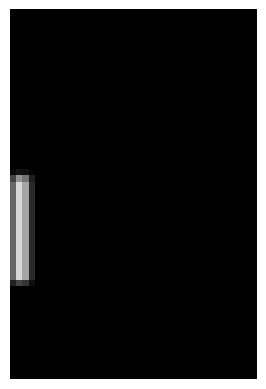

torch.Size([3, 60, 40])


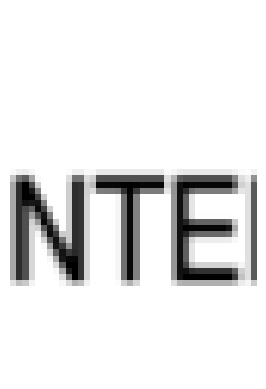

torch.Size([3, 60, 40])


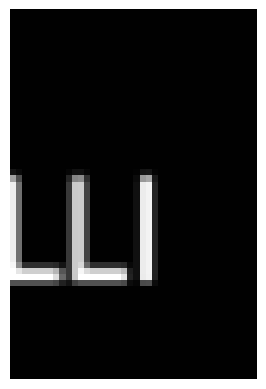

torch.Size([3, 60, 40])


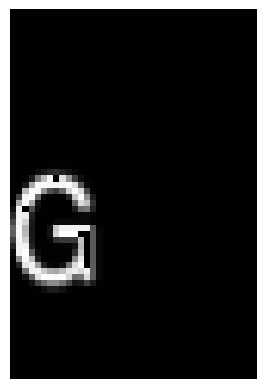

torch.Size([3, 60, 40])


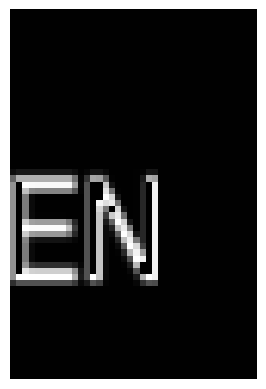

torch.Size([3, 60, 40])


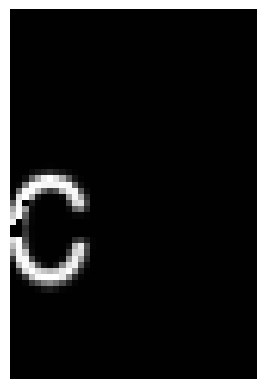

In [194]:
# Try the better segmentation metric
# Looks better!
segments = better_document_segementation("documents/doc1.png")
print(segments)
for i, se in enumerate(segments):
    if i > 5: 
        break
    print(se.shape)
    display_image(se)

In [195]:
# Now try evaluating the accuracy with the better segmentation metric
character_ocr_model = torch.load('model/model.pth')
character_ocr_model.eval()
calculate_accuracy(character_ocr_model, better_document_segementation, "documents", "results")

# It performs better! :)

/var/folders/95/mwnpv8l550l469njbc446kym0000gn/T/ipykernel_50105/2392413553.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  character_ocr_model = torch.load('model/model

Difference between documents/doc3.webp and ocr is: 0.9351851851851852
Difference between documents/doc1.png and ocr is: 0.8700475435816165
Difference between documents/doc2.png and ocr is: 0.8996478873239436
